# Train, Test, Validate Methodology

## Setup
---

### Dataset

https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

Download [CommViolPredUnnormalizedData.txt](https://archive.ics.uci.edu/ml/machine-learning-databases/00211/CommViolPredUnnormalizedData.txt)

### Upload Data

In [1]:
from google.colab import files
upload = files.upload()

Saving CommViolPredUnnormalizedData.txt to CommViolPredUnnormalizedData.txt
Saving CommViolPredUnnormalizedDataHeaders.csv to CommViolPredUnnormalizedDataHeaders.csv


### Alternative for using Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and View the Data

In [4]:
import pandas as pd
import numpy as np

The data file comes without a header column. We could enter this manually but there 147 columns. Let's just use a header file to bring in the column names.

In [5]:
head = pd.read_csv('/content/CommViolPredUnnormalizedDataHeaders.csv')

Now, we can use the column names of this empty DataFrame as the column names of our data file.

In [7]:
df = pd.read_csv('/content/CommViolPredUnnormalizedData.txt', names=head.columns.values.tolist(),
                 na_values='?')

View the first 5 rows of data with `df.head()`.

In [8]:
df.head()

,communityname,State,countyCode,communityCode,fold,pop,perHoush,pctBlack,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,pct65up,persUrban,pctUrban,medIncome,pctWwage,pctWfarm,pctWdiv,pctWsocsec,pctPubAsst,pctRetire,medFamIncome,perCapInc,whitePerCap,blackPerCap,NAperCap,asianPerCap,otherPerCap,hispPerCap,persPoverty,pctPoverty,pctLowEdu,pctNotHSgrad,pctCollGrad,pctUnemploy,pctEmploy,pctEmployMfg,...,policeCalls,policCallPerPop,policCallPerOffic,policePerPop2,racialMatch,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinority,officDrugUnits,numDiffDrugsSeiz,policAveOT,landArea,popDensity,pctUsePubTrans,policCarsAvail,policOperBudget,pctPolicPatrol,gangUnit,pctOfficDrugUnit,policBudgetPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,violentPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.0,NaN,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,3217.7,3.31,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,1,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.0,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,974.2,0.38,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,NaN,NaN,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


## Extract the Data for Analysis

For our analysis we will look at the relationship between violent and non-violent crime.

We want to exclude any data that has `NaN` for the columns of `nonViolPerPop` and `violentPerPop`. Then, we will look at the scatter plot to see what a trend might look like.

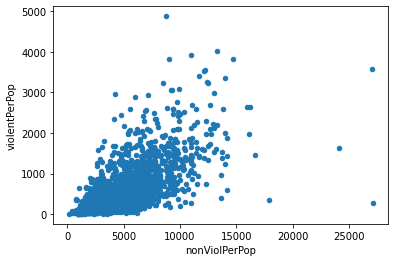

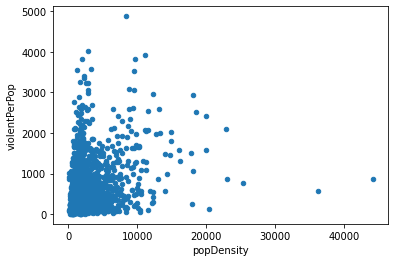

In [14]:
dfcln = df.dropna(subset=['popDensity','nonViolPerPop', 'violentPerPop'])
dfcln.plot.scatter(x='nonViolPerPop',y='violentPerPop')
dfcln.plot.scatter(x='popDensity',y='violentPerPop')

There appears to be an approximatley linear or quadratic relationship between the two measures.

## Manually Fit Linear Model

We will try to fit the data on our own to see how this works. Then we will use the `scikit-learn` tools for fitting the data. 

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [29]:
# Assign the violent crimes data as the Y-data
viol = dfcln['violentPerPop'].values
N = len(viol)
Y_data = viol.copy()

nonviol = dfcln['nonViolPerPop'].values
density = dfcln['popDensity'].values

# Create a 2-D X-data for comparison
X_data = np.ndarray((N,2))
X_data[:,0] = nonviol.copy()
X_data[:,1] = density.copy()

print(f"The number of samples is: {N}")

The number of samples is: 1902


### Set up number of samples in each set

In [39]:
test_pct = 0.1
valid_pct = 0.2

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X_data, Y_data, test_size=test_pct)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, Y_train_valid, test_size=valid_pct)

print(f"Train Size: {len(Y_train)}")
print(f"Validation Size: {len(Y_valid)}")
print(f"Test Size: {len(Y_test)}")

Train Size: 1368
Validation Size: 343
Test Size: 191


### Create Function for Calculating Linear Output

This function will take input data and parameters and return the error score.

In [42]:
def my_simple_fit(X, y, intercept, slopes):
  """
  Calculate mean squared error for manual linear fit.
  """
  ycalc = intercept + slopes @ X.T
  err = mean_squared_error(y, ycalc)
  return err

In [48]:
# Define an intercept and slopes and caluclate the fit
b = 0.0
m = np.array([1.0, 1.0])

err = my_simple_fit(X_train, Y_train, b, m)
print(f"Error is {err}")

Error is 68272492.23196915


In [49]:
# Once the parameters are optimal, compare to the validation set.
val_err = my_simple_fit(X_valid, Y_valid, b, m)
print(f"The validation set error is {val_err}")

The validation set error is 64986467.442342855


### Use Python Tools and Compare

Let's let `scikit-learn` do the calculation and see how we did.

In [50]:
from sklearn.linear_model import LinearRegression

In [52]:
# Create the linear regession object
regr = LinearRegression()

# Use the fit method to create the fit
regr.fit(X_train, Y_train)

# Print the coefficients
print(f"The intercept is {regr.intercept_} and the slopes are {regr.coef_}")

The intercept is -241.55571892233354 and the slopes are [0.14129917 0.04469787]


Now, check the calculated model with the validation data.

In [53]:
Y_pred = regr.predict(X_valid)
mse_pred = mean_squared_error(Y_valid, Y_pred)
print(f"The MSE is {mse_pred}")

The MSE is 176572.9950759024


Finally, check the results against the test data.

In [54]:
Y_pred_test = regr.predict(X_test)
mse_pred_test = mean_squared_error(Y_test, Y_pred_test)
print(f"The MSE is {mse_pred_test}")

The MSE is 170667.74877524204


## Polynomial Regression to the Data

The linear approach was difficult to do manually. The data can be fit with a simple line but is that optimal? Now, we will try to use a polynomial to see how the model fits the data.

In [55]:
from sklearn.preprocessing import PolynomialFeatures

In [59]:
# Set up a quadratic polynomial
quad = PolynomialFeatures(degree=2)

# Create quadratic x-data
Xq_train = quad.fit_transform(X_train)
Xq_valid = quad.fit_transform(X_valid)
Xq_test = quad.fit_transform(X_test)

# Now use the new x-data in the linear regression
qregr = LinearRegression(fit_intercept=False)

qregr.fit(Xq_train, Y_train)

Yq_pred = qregr.predict(Xq_train)
mse_yq_train = mean_squared_error(Y_train, Yq_pred)

# Print the MSE for the training data
print(f"The training data MSE is {mse_yq_train}")

The training data MSE is 179540.9028874867


In [60]:
Yq_valid = qregr.predict(Xq_valid)
Yq_test = qregr.predict(Xq_test)

mse_yq_valid = mean_squared_error(Y_valid, Yq_valid)
mse_yq_test = mean_squared_error(Y_test, Yq_test)

# Print the validation and test results
print(f"The validation set MSE is {mse_yq_valid}")
print(f"The test set MSE is {mse_yq_test}")

The validation set MSE is 172929.94929304364
The test set MSE is 171867.88364944863


## K-Fold Validation

The previous example worked to just demonstrate how each step works. Now, we want to run a cross-validation on the data set to find the results.